Project Charter — Smartphone Battery Life Prediction
Goal

Build a machine learning model that predicts the remaining battery time (in minutes) of a smartphone based on real or simulated usage data.

Prediction Target

minutes_remaining → continuous value
Type: Regression

Success Metric

Primary: MAE (Mean Absolute Error) in minutes

Secondary: RMSE, R²

Why This Project Matters

Accurate battery predictions improve:

User experience

Power management

Device optimization

Data Needed

Battery %

CPU usage

Screen on/off

App usage

Network activity

Timestamps

Data Strategy

Start with synthetic time-series battery logs

Later optionally add real logs or Kaggle datasets

In [ ]:
Day 1 Setup Completed
Folders Created
battery_project/
 ├── data
 ├── notebooks
 ├── src
 ├── models
 └── reports

Git Setup

Initialized repository → git init

Added README

First commit → "project scaffold"

Conda Environment

Created environment:

conda create -n batteryml python=3.10
conda activate batteryml

Installed Libraries
numpy
pandas
matplotlib
seaborn
scikit-learn
jupyterlab

Next Steps

Create synthetic dataset

Explore features

Build baseline model

In [2]:
import numpy, pandas, sklearn
print("NumPy:", numpy.__version__)
print("Pandas:", pandas.__version__)
print("scikit-learn:", sklearn.__version__)
print("\nEnvironment OK ✔")


NumPy: 2.3.5
Pandas: 2.3.3
scikit-learn: 1.7.1

Environment OK ✔


In [ ]:
Synthetic Data — purpose & notes

We generate a small, realistic-ish session so you can implement baseline models and iterate without waiting for real logs. This generator provides minute-level telemetry, CPU and screen usage, and a computed ground-truth minutes_remaining_target.

In [9]:
import os
os.getcwd()


'C:\\Users\\madan\\battery_project\\notebooks'

In [10]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

def simulate_session(start_percent=90, minutes=240, base_drain_per_min=0.08, seed=1):
    np.random.seed(seed)
    times = [datetime.now() + timedelta(minutes=i) for i in range(minutes)]
    cpu = np.clip(np.random.normal(loc=20, scale=10, size=minutes), 0, 100)
    screen_on = (np.random.rand(minutes) < 0.35).astype(int)
    drain = base_drain_per_min + (cpu/100)*0.18 + screen_on*0.45 + np.random.normal(0, 0.02, minutes)
    percent = np.maximum(0, start_percent - np.cumsum(drain))
    df = pd.DataFrame({
        'timestamp': times,
        'battery_percent': np.round(percent,3),
        'cpu_pct': np.round(cpu,2),
        'screen_on': screen_on,
        'drain_per_min': np.round(drain,4),
    })
    minutes_remaining = []
    for i in range(len(df)):
        current_pct = df.loc[i, 'battery_percent']
        future_drains = df.loc[i:, 'drain_per_min'].values
        avg_future = future_drains.mean() if future_drains.size else np.nan
        rem = int(np.ceil(current_pct / avg_future)) if avg_future > 0 else 0
        minutes_remaining.append(rem)
    df['minutes_remaining_target'] = minutes_remaining
    return df

df = simulate_session(start_percent=95, minutes=300, base_drain_per_min=0.06, seed=42)
df.head()


,timestamp,battery_percent,cpu_pct,screen_on,drain_per_min,minutes_remaining_target
0,2025-12-03 19:31:44.461065,94.478,24.97,1,0.5216,378
1,2025-12-03 19:32:44.461085,93.924,18.62,1,0.5544,377
2,2025-12-03 19:33:44.461090,93.830,26.48,0,0.0944,379
3,2025-12-03 19:34:44.461094,93.695,35.23,0,0.1348,377
4,2025-12-03 19:35:44.461098,93.618,17.66,0,0.0765,376


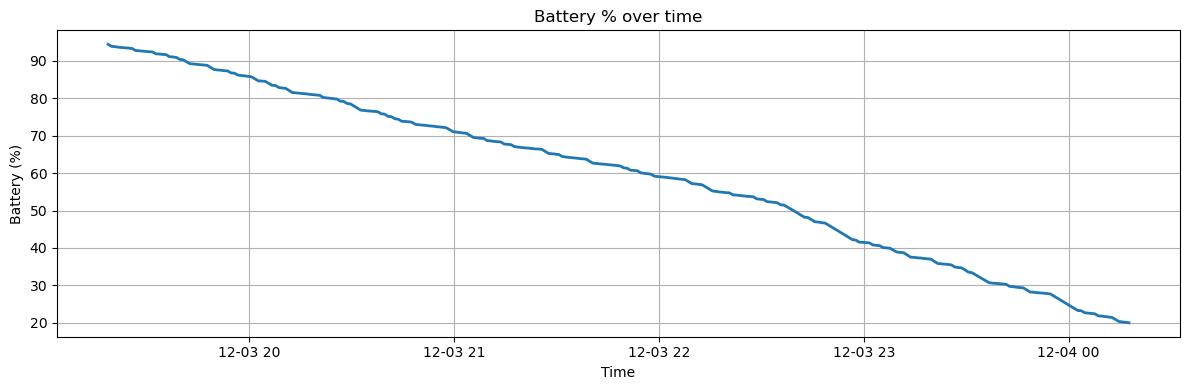

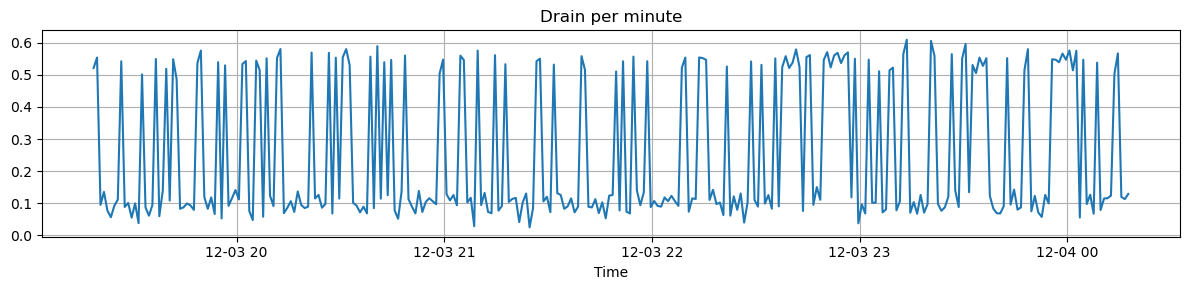

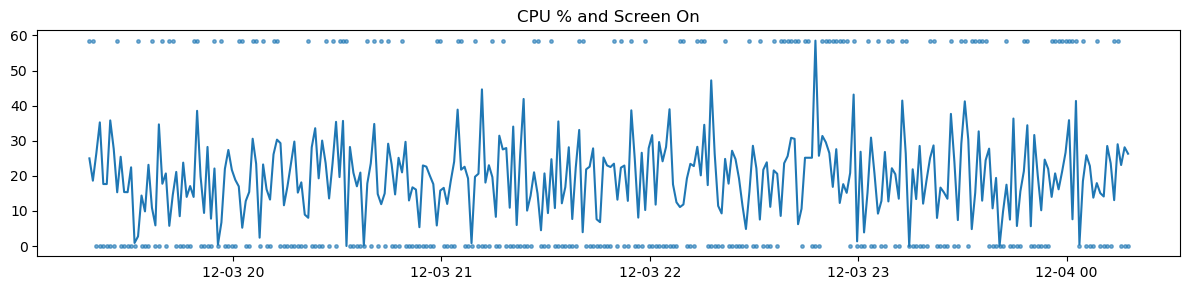

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("../data/synthetic_session1.csv", parse_dates=['timestamp'])

plt.figure(figsize=(12,4))
plt.plot(df['timestamp'], df['battery_percent'], label='battery_percent', linewidth=2)
plt.xlabel("Time"); plt.ylabel("Battery (%)"); plt.title("Battery % over time"); plt.grid(True); plt.tight_layout()
plt.show()

plt.figure(figsize=(12,3))
plt.plot(df['timestamp'], df['drain_per_min'], label='drain_per_min')
plt.xlabel("Time"); plt.title("Drain per minute"); plt.grid(True); plt.tight_layout(); plt.show()

plt.figure(figsize=(12,3))
plt.plot(df['timestamp'], df['cpu_pct'], label='cpu_pct')
plt.scatter(df['timestamp'], df['screen_on']*df['cpu_pct'].max(), label='screen_on (scaled)', s=6, alpha=0.6)
plt.title("CPU % and Screen On"); plt.tight_layout(); plt.show()


In [12]:
import numpy as np
from sklearn.metrics import mean_absolute_error
avg_drain = df['drain_per_min'].mean()
df['baseline_global'] = (df['battery_percent'] / avg_drain).round().astype(int)

N = 10
df['rolling_avg_drain'] = df['drain_per_min'].rolling(window=N, min_periods=1).mean()
df['baseline_rolling'] = (df['battery_percent'] / df['rolling_avg_drain']).replace([np.inf, -np.inf], np.nan).fillna(0).round().astype(int)

mae_global = mean_absolute_error(df['minutes_remaining_target'], df['baseline_global'])
mae_rolling = mean_absolute_error(df['minutes_remaining_target'], df['baseline_rolling'])

print(f"MAE global baseline: {mae_global:.2f} minutes")
print(f"MAE rolling-{N} baseline: {mae_rolling:.2f} minutes")

df[['timestamp','battery_percent','drain_per_min','minutes_remaining_target','baseline_global','baseline_rolling']].head(12)


MAE global baseline: 16.11 minutes
MAE rolling-10 baseline: 71.56 minutes


,timestamp,battery_percent,drain_per_min,minutes_remaining_target,baseline_global,baseline_rolling
0,2025-12-03 19:18:39.320908,94.478,0.5216,378,378,181
1,2025-12-03 19:19:39.320926,93.924,0.5544,377,375,175
2,2025-12-03 19:20:39.320931,93.830,0.0944,379,375,241
3,2025-12-03 19:21:39.320934,93.695,0.1348,377,375,287
4,2025-12-03 19:22:39.320938,93.618,0.0765,376,374,339
5,2025-12-03 19:23:39.320941,93.563,0.0557,375,374,391
6,2025-12-03 19:24:39.320945,93.471,0.0919,374,374,428
7,2025-12-03 19:25:39.320948,93.360,0.1108,373,373,455
8,2025-12-03 19:26:39.320951,92.817,0.5427,370,371,383
9,2025-12-03 19:27:39.320955,92.730,0.0877,371,371,408


In [13]:
light = simulate_session(start_percent=95, minutes=300, base_drain_per_min=0.03, seed=101)
heavy = simulate_session(start_percent=95, minutes=300, base_drain_per_min=0.12, seed=303)
light.to_csv("../data/synthetic_session_light.csv", index=False)
heavy.to_csv("../data/synthetic_session_heavy.csv", index=False)
print("Saved:", os.listdir("../data"))


Saved: ['init', 'synthetic_session1.csv', 'synthetic_session_heavy.csv', 'synthetic_session_light.csv']


In [14]:
import os
path = "../data/synthetic_session1.csv"
print("saved:", os.path.exists(path))


saved: True
